# mandelbrot

In [1]:
import tensorflow as tf
import numpy as np

import PIL.Image
from io import BytesIO
from IPython.display import Image, display

In [2]:
def get_meshgrid(X, Y, R, n_x=1000):
    x_ubd, x_lbd = X + R, X - R
    y_ubd, y_lbd = Y + R, Y - R
    
    step_x = (x_ubd - x_lbd) / n_x
    n_y = int(np.ceil((y_ubd - y_lbd) / step_x))
    
    x_rng = np.linspace(x_lbd, x_ubd, n_x, dtype=np.float64)
    y_rng = np.linspace(y_lbd, y_ubd, n_y, dtype=np.float64)
    
    X, Y = np.meshgrid(x_rng, y_rng)
    Z = X + 1j*Y
    return Z

In [3]:
def display_fractal(a, fmt='png'):

    # cyclically color the points by number of iterations to diverge
    cycle_steps = 20 # number of steps before colors cycle
    a_cyclic = 2 * np.pi * a / cycle_steps
    rgb = [127 + 80 * np.cos(a_cyclic),
           127 + 80 * np.sin(a_cyclic),
           127 + 80 * np.cos(a_cyclic)]
    img = np.stack(rgb, 2)

    # color points which never diverged black
    img[a == a.max()] = 0
    img = np.uint8(img)
    
    # display the image
    f = BytesIO()
    PIL.Image.fromarray(img).save(f, fmt)
    display(Image(data=f.getvalue()))

In [5]:
# center
X = 0.0
Y = 0.0
R = 2.0

# interesting spot
# X = 0.267235642726
# Y = -0.003347589624
# R = 1.15E-10

Z = get_meshgrid(X, Y, R)

In [6]:
tf.reset_default_graph()

xs = tf.constant(Z, name='xs')
zs = tf.Variable(xs, name='zs')
ns = tf.Variable(tf.zeros_like(xs, tf.float32), name='ns')

c = tf.constant(-0.624 + 0.435j, name='c')

# zs_ = zs * zs + xs # mandelbrot
zs_ = zs**2 + c # julia
not_diverged = tf.abs(zs_) < 4 # uses zs_ instead of zs, therefore the first circle is at radius 2.0

update_zs = zs.assign(zs_)
update_ns = ns.assign_add(tf.cast(not_diverged, tf.float32))
update_step = tf.group(update_zs, update_ns)

init_op = tf.global_variables_initializer()

writer = tf.summary.FileWriter('./logdir')
writer.add_graph(tf.get_default_graph())

with tf.Session() as sess:
    init_op.run()
    for i in range(512):
        update_step.run()
    
    ns_np = ns.eval()

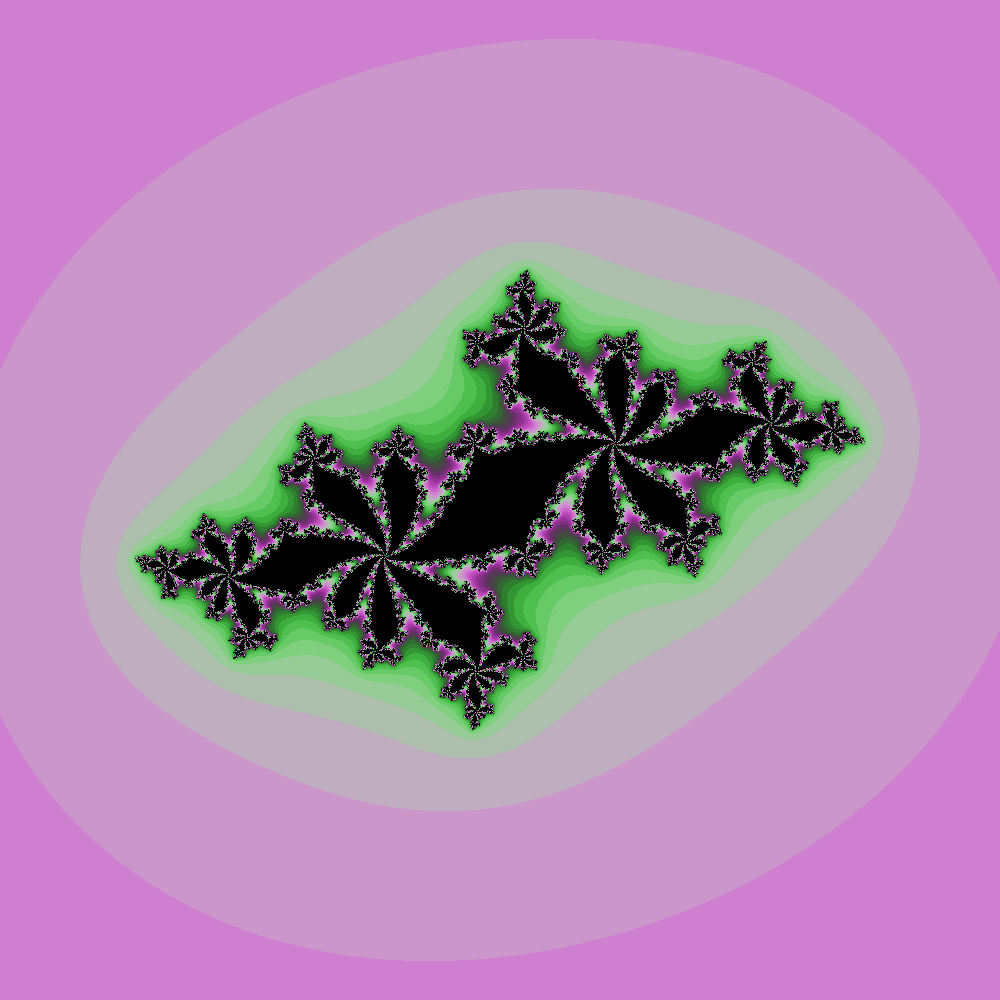

In [7]:
display_fractal(ns_np)